<div style="background-color: #c3e8fb; padding: 10px; color: #144d84;">
<b>Exercise 1) Text Classifier with Recurrent Model</b><br>
Please choose one of the text classification exercises we did in class (e.g., IMDB) and solve it using a recurrent neural network such as GRU or LSTM. Did the accuracy improve or worsen compared to before? Why do you think this happened?
</div>

In [1]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz

--2025-01-14 07:04:45--  https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.188.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6053168 (5.8M) [application/x-gzip]
Saving to: ‘stack_overflow_16k.tar.gz’

stack_overflow_16k. 100%[===================>]   5.77M  --.-KB/s    in 0.1s    

2025-01-14 07:04:45 (60.5 MB/s) - ‘stack_overflow_16k.tar.gz’ saved [6053168/6053168]



In [2]:
!tar -xzf stack_overflow_16k.tar.gz

In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
print(len(os.listdir('train/csharp')))
print(len(os.listdir('train/java')))
print(len(os.listdir('train/javascript')))
print(len(os.listdir('train/python')))

2000
2000
2000
2000


In [5]:
# calculating the mean number of words in files. so that we can decide whether or not 250 is a good size for vectors

def count_words_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
        words = text.split()
        return len(words)

def calculate_word_statistics(root_dir):
    word_counts = []

    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.txt'):
                file_path = os.path.join(dirpath, filename)
                word_count = count_words_in_file(file_path)
                word_counts.append(word_count)

    if word_counts:
        mean_word_count = np.mean(word_counts)
        median_word_count = np.median(word_counts)
    else:
        mean_word_count = 0
        median_word_count = 0

    return mean_word_count, median_word_count

root_directory = 'train'
mean_count, median_count = calculate_word_statistics(root_directory)

print(f"Mean number of words: {mean_count}")
print(f"Median number of words: {median_count}")

Mean number of words: 137.056875
Median number of words: 102.0


seems good.

### Loading the data

In [6]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


### Standardizing and Tokenizing

In [7]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return stripped_html

In [8]:
max_features = 10000
sequence_length = 300

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
    ngrams=(1,2))

In [9]:
# adapt to get the tokens (vocabulary)
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [10]:
for data, label in raw_train_ds.take(3):
    print("data: ", data.shape)
    print('label: ', label.shape)

data:  (32,)
label:  (32,)
data:  (32,)
label:  (32,)
data:  (32,)
label:  (32,)


In [11]:
for data in train_text.take(3):
    print("data: ", data.shape)

data:  (32,)
data:  (32,)
data:  (32,)


In [12]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 '=',
 'to',
 'i',
 'a',
 'in',
 'is',
 '{.',
 'and',
 'of',
 'if',
 'for',
 'it',
 'that',
 'this',
 '+',
 'new',
 'have',
 '}.',
 'with',
 '= new',
 'string',
 'not',
 'my',
 '.',
 'but',
 'return',
 'public',
 'blank',
 'an',
 'from',
 'be',
 'am',
 'class',
 'can',
 'as',
 'i have',
 'code',
 'on',
 '==',
 'int',
 'how',
 'void',
 'do',
 '}..',
 'i am',
 'want',
 'or',
 'when',
 'get',
 'file',
 'using',
 'like',
 'of the',
 '//',
 'function',
 'var',
 'static',
 'in the',
 '*',
 '""',
 '-',
 'so',
 "i'm",
 'are',
 'want to',
 'at',
 'what',
 'would',
 'you',
 'which',
 '{',
 'there',
 'will',
 'use',
 'i want',
 'list',
 'value',
 'all',
 'one',
 'method',
 'by',
 'any',
 'need',
 'object',
 '&lt;',
 'else',
 'trying',
 'me',
 'some',
 ':',
 'trying to',
 'is the',
 'number',
 'to the',
 'then',
 'print',
 'have a',
 'way',
 '"how',
 'line',
 'should',
 'how to',
 'private',
 '}',
 'error',
 'only',
 'has',
 '"" +',
 'array',
 'data',
 'into',
 'know',
 'jus

In [13]:
vectorize_layer("this code is such a mess ARRR!!")

<tf.Tensor: shape=(300,), dtype=int64, numpy=
array([  16,   39,    8,  473,    6,    1,    1,  483,  550,    1, 2456,
          1,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

### Vectorizing the whole data

In [14]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1) # was it realy needed ???
  return vectorize_layer(text), label

In [15]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [16]:
for t,l in train_ds.take(1):
  print(t, l)

tf.Tensor(
[[   1   30    4 ...    1    1    1]
 [ 101   45    5 ...    0    0    0]
 [4236   31  111 ...    1   61    5]
 ...
 [ 101    4  256 ...    0    0    0]
 [ 626    2    1 ...    0    0    0]
 [   1 1464  118 ...    0    0    0]], shape=(32, 300), dtype=int64) tf.Tensor([3 3 2 0 0 0 2 0 2 1 0 1 0 1 0 0 1 0 1 2 1 0 0 1 2 2 1 0 0 2 2 1], shape=(32,), dtype=int32)


In [17]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Create the model and train it

In [18]:
embedding_dim = 16
# max_features = 10000

In [20]:
# model = tf.keras.Sequential([
#   layers.Embedding(max_features, embedding_dim), # (10000, 16)
#   layers.Dropout(0.2),
#   layers.GlobalAveragePooling1D(),
#   layers.Dropout(0.2),
#   layers.Dense(16, activation='relu'),
#   layers.Dense(4)
#   ])


# model = tf.keras.Sequential([
#     layers.Embedding(input_dim=max_features, output_dim=embedding_dim),
#     layers.Dropout(0.2),
#     layers.GRU(128, return_sequences=True),
#     layers.Dropout(0.2),
#     layers.GRU(64),
#     layers.Dropout(0.2),
#     layers.Dense(4)
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        # Used masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4)
])

In [21]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_lr=1e-7
)

In [24]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 1.3750 - sparse_categorical_accuracy: 0.2671 - val_loss: 1.1267 - val_sparse_categorical_accuracy: 0.4931 - learning_rate: 0.0010
Epoch 2/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.0050 - sparse_categorical_accuracy: 0.5720 - val_loss: 0.8650 - val_sparse_categorical_accuracy: 0.6388 - learning_rate: 0.0010
Epoch 3/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.7146 - sparse_categorical_accuracy: 0.6997 - val_loss: 0.7176 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 4/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.4530 - sparse_categorical_accuracy: 0.8364 - val_loss: 0.9225 - val_sparse_categorical_accuracy: 0.7006 - learning_rate: 0.0010
Epoch 5/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.3087 - sparse_categorical_accuracy: 0.8979 - val_loss: 0.9203 - val_sparse_categorical_accuracy: 0.6831 - learning_rate: 0.0010
Epoch 6/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 2

مشاهده میشود که دقت روی دیتای ولیدیشن بیشتر نشد.   
قبلا روی دیتای ولیدیشن به دقت ۸۰ دست یافته بودم.

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.7675 - sparse_categorical_accuracy: 0.7001
Loss:  0.772243320941925
Accuracy:  0.6953750252723694


### Plotting the loss and accuracy

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'learning_rate'])

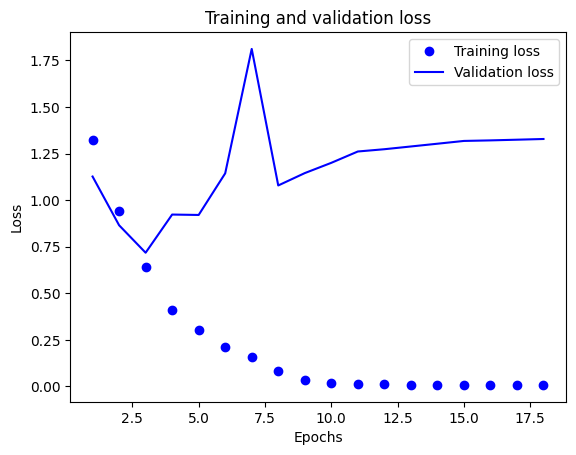

In [27]:
acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

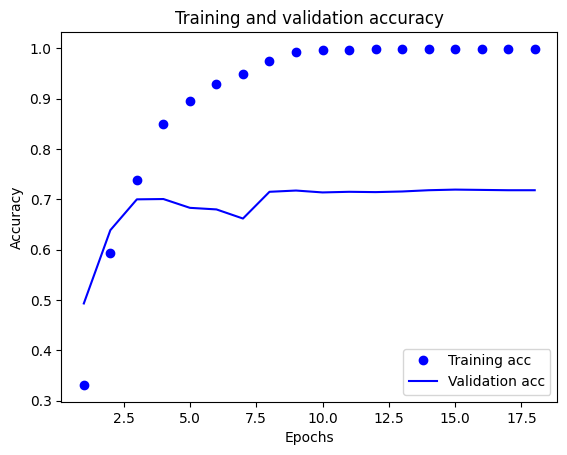

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Create export model

In [29]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

export_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [30]:
export_model.evaluate(raw_test_ds)

  1/250 ━━━━━━━━━━━━━━━━━━━━ 1:44 421ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.6875

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.6988


[0.0, 0.0, 0.6953750252723694, 0.6953750252723694]

In [31]:
classes = raw_test_ds.class_names
classes

['csharp', 'java', 'javascript', 'python']

In [32]:
examples = [
  ['this is my funtion in python: def func(c): print(c)'],
]

classes[np.argmax(export_model.predict(tf.data.Dataset.from_tensor_slices(examples)))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


'python'

In [33]:
examples = [
  ['what is the problem with this code?  class A(b){ system.out.pritln(b)}. this java code has a problem'],
]

classes[np.argmax(export_model.predict(tf.data.Dataset.from_tensor_slices(examples)))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


'java'